In [1]:
#data format library
import h5py

#numpy
import numpy as np
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time
import simulation_functions as sfs

np.random.seed(42)

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
#shapes are n_fish, max_n_bouts,dim of variable
X_head_allcond = ma.array(f['head_pos'])
f.close()
X_head_allcond[X_head_allcond == 0] = ma.masked

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

In [5]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [6]:
## For Fig 3B, Fig 5E and Fig Suppl 8

In [7]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/'
f = h5py.File(path_to_filtered_data + 'pool_ex8_PCs/kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

to_mask = 1300
labels_fish[labels_fish == to_mask] = ma.masked

labels_all= ma.concatenate(labels_fish,axis=0)

In [11]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [13]:
maxL = np.max(lengths_all)
X_head = X_head_allcond[:,:maxL,:,:]

In [14]:
for i in range(X_head.shape[0]):
    if conditions[i,1] in condition_labels[9:]:
        ps = 365.
    else:
        ps = 170.
    print(i,conditions[i,1],ps)
    X_head[i] = X_head[i]/ps

0 3 min Light<->Dark(5x5cm) 170.0
1 3 min Light<->Dark(5x5cm) 170.0
2 3 min Light<->Dark(5x5cm) 170.0
3 3 min Light<->Dark(5x5cm) 170.0
4 3 min Light<->Dark(5x5cm) 170.0
5 3 min Light<->Dark(5x5cm) 170.0
6 3 min Light<->Dark(5x5cm) 170.0
7 3 min Light<->Dark(5x5cm) 170.0
8 3 min Light<->Dark(5x5cm) 170.0
9 3 min Light<->Dark(5x5cm) 170.0
10 3 min Light<->Dark(5x5cm) 170.0
11 3 min Light<->Dark(5x5cm) 170.0
12 3 min Light<->Dark(5x5cm) 170.0
13 3 min Light<->Dark(5x5cm) 170.0
14 3 min Light<->Dark(5x5cm) 170.0
15 3 min Light<->Dark(5x5cm) 170.0
16 3 min Light<->Dark(5x5cm) 170.0
17 3 min Light<->Dark(5x5cm) 170.0
18 3 min Light<->Dark(5x5cm) 170.0
19 3 min Light<->Dark(5x5cm) 170.0
20 3 min Light<->Dark(5x5cm) 170.0
21 3 min Light<->Dark(5x5cm) 170.0
22 Dark_Transitions(5x5cm) 170.0
23 Dark_Transitions(5x5cm) 170.0
24 Dark_Transitions(5x5cm) 170.0
25 Dark_Transitions(5x5cm) 170.0
26 Dark_Transitions(5x5cm) 170.0
27 Dark_Transitions(5x5cm) 170.0
28 Dark_Transitions(5x5cm) 170.0
29 Dark_T

In [15]:
print(X_head.shape)

(463, 11651, 175, 2)


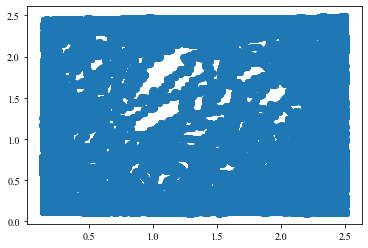

In [16]:
plt.scatter(X_head[232,:,:,0],X_head[232,:,:,1])

### Simulations from fish in large arenas - Fig S8

In [17]:
conds = [0,1,2,3,4,5,6,7,8]
cond_recs = []
for c in conds:
    cond_recs.extend(np.where(conditions[:,1] == condition_labels[c])[0])

In [18]:
# pca_pose = pca_fish[krec0:krec1,:,:20].copy()

X = ma.vstack(X_head[cond_recs].copy())

vecX = ma.diff(X[:,0,:],axis=0)
dist = ma.zeros(X.shape[0])
dist[:-1] = ma.sqrt(vecX[:,0]**2+vecX[:,1]**2)
dist[-1] = ma.masked 

psi = ma.zeros(X.shape[0])
psi[:-1] = ma.arctan2(vecX[:,1],vecX[:,0])
psi[-1] = ma.masked

psi_unwrap = sfs.unwrapma(psi)
dpsi = ma.zeros(X.shape[0])
dpsi[:-1] = psi_unwrap[1:]-psi_unwrap[:-1]
dpsi[-1:] = ma.masked

In [19]:
psi_fish = psi.reshape((X_head[cond_recs].shape[0], X_head[cond_recs].shape[1]))

In [20]:
labels_cond = ma.hstack(labels_fish[cond_recs])

In [21]:
lookup_table = {}
for state in np.unique(labels_cond.compressed()):
    mask = labels_cond==state
    lookup_table[state] = np.arange(len(labels_cond))[mask]

In [22]:
rec_X_traj = []

for i,c in enumerate(cond_recs):
    labels = labels_fish[c]
    print(i)
    dpsi_rec = np.array([dpsi[lookup_table[s][np.random.randint(0,len(lookup_table[s]))]] for s in labels.compressed()])
    dist_rec = np.array([dist[lookup_table[s][np.random.randint(0,len(lookup_table[s]))]] for s in labels.compressed()])
    rec_X_traj.append(sfs.rec_trajectory(dpsi_rec,dist_rec,psi_fish[i,0],X_head[cond_recs][i,0,0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212


In [23]:
## Simulate from ensemble operator
lcs_cond, P_cond = op_calc.transition_matrix(labels_cond,delay=3,return_connected=True)
sims = sfs.get_sims_ensemble(labels_cond, P_cond,n_sims=1000, len_sim=1000)

(1200,)


In [24]:
print(len(sims))

1000


In [25]:
xmin=0
xmax = 5.0
sims_X_traj = []
sims_X_traj_refl = []
for i, sim in enumerate(sims):
    print(i)
    dpsi_sim = np.array([dpsi[lookup_table[s][np.random.randint(0,len(lookup_table[s]))]] for s in sim])
    dist_sim = np.array([dist[lookup_table[s][np.random.randint(0,len(lookup_table[s]))]] for s in sim])
    sims_X_traj.append(ma.array(sfs.rec_trajectory(dpsi_sim,dist_sim,np.random.choice(psi_fish[:,0]),[0,0])))
    sims_X_traj_refl.append(ma.array(sfs.rec_trajectory_reflective(dpsi_sim,dist_sim,np.random.choice(psi_fish[:,0]),[0.4,0.4],xmin,xmax)))

0
1
2
3
4
5
! [0.12273935 4.86100561] [-2.42801399e-03  5.26219158e+00] [0.24790672 5.26219158]
fixed [0.24790672 4.73780842]
! [4.88750084e+00 5.05332443e-04] [ 5.02198475 -0.1465399 ] [ 4.75301694 -0.1465399 ]
fixed [4.75301694 0.1465399 ]
! [0.19456249 0.07759656] [-0.04511978 -0.12734986] [ 0.43424475 -0.12734986]
fixed [0.43424475 0.12734986]
6
7
! [4.99332378 0.26841881] [ 5.60935131 -0.23331924] [ 4.37729624 -0.23331924]
fixed [4.37729624 0.23331924]
! [4.70032141 0.04543844] [ 5.417128   -0.02953021] [ 3.98351482 -0.02953021]
fixed [3.98351482 0.02953021]
8
! [0.07722212 4.91581059] [-0.09300489  5.02100178] [0.24744913 5.02100178]
fixed [0.24744913 4.97899822]
9
10
11
12
13
14
15
16
17
! [0.07049736 0.05347491] [-0.27252101 -0.16886127] [ 0.41351574 -0.16886127]
fixed [0.41351574 0.16886127]
! [0.05662766 0.07361642] [-0.21720535 -0.0870801 ] [ 0.33046067 -0.0870801 ]
fixed [0.33046067 0.0870801 ]
! [0.33761461 4.86750505] [-0.02221018  5.04705948] [0.6974394  5.04705948]
fixe

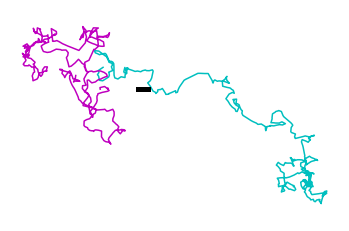

In [26]:
idx = 13
# print(len(rec_X_traj[idx]))
# plt.figure(figsize=(5,5))
# plt.plot(X_head[cond_recs][idx][0:500,0,0],X_head[cond_recs][idx][0:500,0,1],c='k')#, c=np.arange(len(rec_X_traj[sims_fishnum[idx]])), cmap='viridis', s=10)
# plt.plot([4,5],[0,0],lw=5,c='k')
# plt.axis('equal')
# plt.axis('off')

plt.plot(rec_X_traj[idx][:500,0],rec_X_traj[idx][:500,1],c='c')#, c=np.arange(len(rec_X_traj[sims_fishnum[idx]])), cmap='viridis', s=10)
plt.axis('equal')
plt.axis('off')
plt.plot([4,5],[0,0],lw=5,c='k')

plt.plot(sims_X_traj[idx][:500,0],sims_X_traj[idx][:500,1],c='m')# ,c=np.arange(len(sims_X_traj[idx])), cmap='viridis', s=10)
plt.axis('equal')
plt.axis('off')
plt.plot([4,5],[0,0],lw=5,c='k')
# plt.plot(sims_X_traj_refl[idx][:500,0],sims_X_traj_refl[idx][:500,1],c='brown')# ,c=np.arange(len(sims_X_traj_refl[idx])), cmap='viridis', s=10)
# plt.axis('equal')
# plt.axis('off')
# plt.plot([4,5],[0,0],lw=5,c='k')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl8/new_trajs.pdf')
plt.show()

In [85]:
lags = np.arange(0,500)
realdat_msds = []
for i in cond_recs:
    print(i)
    realdat_msd,_ = sfs.MSD_unc(X_head[i,:,0,:],lags)
    realdat_msds.append(realdat_msd)

453
454
455
456
457
458
459
460
461
462
121
122
123
124
125
126
127
128
129
130
131
132
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
443
444
445
446
447
448
449
450
451
452
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [28]:
lags = np.arange(0,500)
rec_msds = []
sim_msds = []
refls_msds = []
for i in range(len(rec_X_traj)):
    print(i)
    rec_msd,_ = sfs.MSD_unc(rec_X_traj[i],lags)
    rec_msds.append(rec_msd)

for i in range(len(sims_X_traj)):
    print(i)
    sim_msd,_ = sfs.MSD_unc(sims_X_traj[i],lags)
    sim_msds.append(sim_msd)
    refl_msd,_ = sfs.MSD_unc(sims_X_traj_refl[i],lags)
    refls_msds.append(refl_msd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
8

<ipython-input-30-5886de64b1fd>:7: RuntimeWarning: divide by zero encountered in log
  local_slope_real = np.diff(np.log(mean))/np.diff(np.log(lags))
<ipython-input-30-5886de64b1fd>:12: RuntimeWarning: divide by zero encountered in log
  local_slope_sim = np.diff(np.log(mean))/np.diff(np.log(lags))
<ipython-input-30-5886de64b1fd>:22: RuntimeWarning: divide by zero encountered in log
  local_slope_dat = np.diff(np.log(mean))/np.diff(np.log(lags))


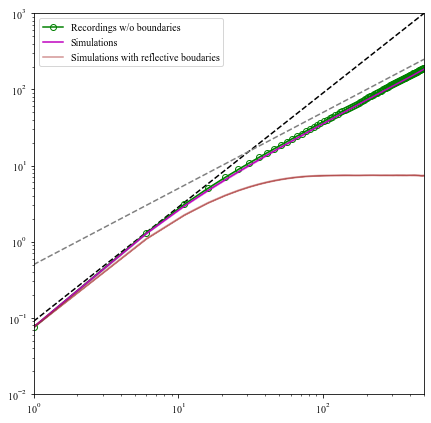

In [30]:
plt.figure(figsize=(7,7))

plt.plot(lags[1:], 0.09*lags[1:]**1.5,c='k',ls='--')
plt.plot(lags[1:], 0.5*lags[1:]**1.,c='gray',ls='--')

mean,cil,ciu = stats.bootstrap(rec_msds,n_times=100, n_samples=len(rec_msds))
local_slope_real = np.diff(np.log(mean))/np.diff(np.log(lags))
plt.plot(lags[1::5],mean[1::5],alpha=1.,label='Recordings w/o boundaries', c='green', fillstyle='none',marker='o')
plt.fill_between(lags[1::5],cil[1::5],ciu[1::5],alpha=.3, color='green')

mean,cil,ciu = stats.bootstrap(sim_msds,n_times=100,n_samples=len(sim_msds))
local_slope_sim = np.diff(np.log(mean))/np.diff(np.log(lags))
plt.plot(lags[1::5],mean[1::5],alpha=1.,label='Simulations',c='m')
plt.fill_between(lags[1::5],cil[1::5],ciu[1::5],alpha=.3, color='m')

mean,cil,ciu = stats.bootstrap(realdat_msds,n_times=100,n_samples=len(realdat_msds))
local_slope_dat = np.diff(np.log(mean))/np.diff(np.log(lags))
plt.plot(lags[1::5],mean[1::5],marker='*',label='data',c='k', alpha=0.5)
plt.fill_between(lags[1::5],cil[1::5],ciu[1::5],color='k',alpha=.3)

mean,cil,ciu = stats.bootstrap(refls_msds,n_times=100, n_samples=len(refls_msds))
local_slope_dat = np.diff(np.log(mean))/np.diff(np.log(lags))
plt.plot(lags[1::5],mean[1::5],alpha=0.5,label='Simulations with reflective boudaries',c='brown')
plt.fill_between(lags[1::5],cil[1::5],ciu[1::5],alpha=.5,color='brown')
plt.xlim(1,500)
plt.ylim(0.01,1000)
plt.xscale('log')
plt.yscale('log')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl8/MSD_refl_new.pdf')
# plt.xlim(0,30)
plt.legend()

### Metastable state MSD

In [25]:
st_colors = ['#343B97', '#00B4F0', '#FBDD2B', '#8D2B24']

In [19]:
len_sim = 1000
sims_Xs_trajs = [[],[],[],[]]
for ms in range(4):
    Xs = []
    for idx in range(50):
        f = h5py.File(path_to_filtered_data + 'zebrafish_ms_sims/sims_lensim_{}_state_{}_{}.h5'.format(len_sim,ms,idx),'r')
        X_sims = np.array(f['sims_X'])
        f.close()
        Xs.append(X_sims)
    Xs = ma.concatenate(Xs,axis=0)
    sims_Xs_trajs[ms] = Xs

n_sims = Xs.shape[0]

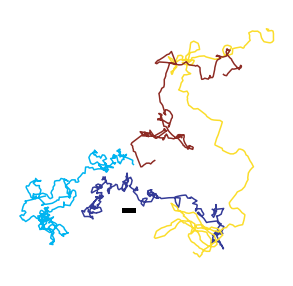

In [31]:
idx =133
fig, ax = plt.subplots(1,1,figsize=(5,5))
for ms in [0,1,2,3]:
    if ms == 0:
        x_off,y_off = 0,0
    elif ms == 1:
        x_off,y_off = 5,5
    elif ms == 2:
        x_off,y_off = 20,20
    elif ms == 3:
        x_off,y_off = 15,15
    
    plt.plot(x_off + sims_Xs_trajs[ms][idx][:500,0],y_off+sims_Xs_trajs[ms][idx][:500,1], c=st_colors[ms])#c=np.arange(1000), cmap='viridis', s=10)
ax.plot([4,5],[0,0],lw=5,c='k')
plt.axis('equal')
plt.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig6/MS_sim_traj.pdf')
plt.show()
# for ms in np.unique(km.labels_):
#     plt.plot(sims_X_trajs[ms][idx][:1000,0],sims_X_trajs[ms][idx][:1000,1], c=st_colors[ms])#c=np.arange(1000), cmap='viridis', s=10)
#     plt.axis('equal')
#     plt.show()

In [22]:
lags = np.arange(0,500)
mus_sim=[[],[],[],[]]
for ms in range(4):
    print(ms)
    for k in range(n_sims):
        mu,Unc = sfs.MSD_unc(sims_Xs_trajs[ms][k],lags)
        mus_sim[ms].append(mu)

0
1
2
3


0


<ipython-input-26-6dccb2f62711>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


1


<ipython-input-26-6dccb2f62711>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


2


<ipython-input-26-6dccb2f62711>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


3


<ipython-input-26-6dccb2f62711>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


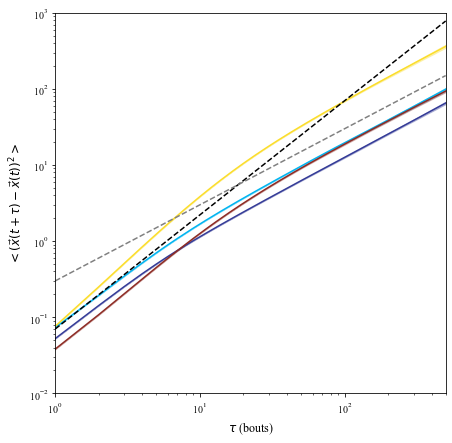

In [26]:
plt.figure(figsize=(7,7))

local_slopes =[]

for ms in range(4):
    print(ms)
    mean,cil,ciu = stats.bootstrap(mus_sim[ms],n_times=100, n_samples=len(mus_sim[ms]))
    local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))
    local_slopes.append(local_slope)
    plt.plot(lags[1:],mean[1:],c=st_colors[ms])
    plt.fill_between(lags[1:],cil[1:],ciu[1:],alpha=.3,color=st_colors[ms])

plt.plot(lags[1:], 0.07*lags[1:]**1.5,c='k',ls='--')
plt.plot(lags[1:], 0.3*lags[1:]**1.,c='gray',ls='--')
plt.xlim(1,500)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.1,1)
# plt.xlim(0,15)
plt.ylim(0.01,1000)
plt.xlabel(r'$\tau$ (bouts)',fontsize=12)
plt.ylabel(r'$<(\vec{x}(t+\tau)-\vec{x}(t))^2>$',fontsize=12)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl8/MSD_metastates.pdf')
# plt.legend()
# plt.axis('equal')
plt.show()

## Phenotypic group MSD

In [38]:
tmspace_clusters = np.load('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/spectral_split_g7.npy')

In [45]:
len_sim = 1000
sims_gs_X_trajs = [[],[],[],[],[],[],[]]

for kg in np.unique(tmspace_clusters):
    Xs=[]
    for idx in range(50):
        f = h5py.File(path_to_filtered_data+'zebrafish_ms_sims/sims_lensim_{}_group_{}_{}.h5'.format(len_sim,kg,idx),'r')
        X_sims = np.array(f['sims_gs_X'])
        f.close()
        Xs.append(X_sims)
    Xs = ma.concatenate(Xs,axis=0)
    sims_gs_X_trajs[kg] = Xs

n_sims = Xs.shape[0]

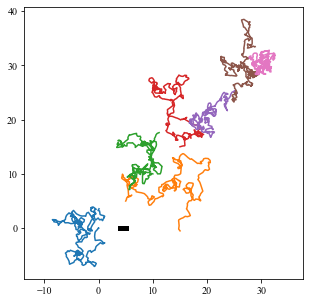

In [46]:
idx =300
fig, ax = plt.subplots(1,1,figsize=(5,5))
for clus in [0,1,2,3,4,5,6]:
    if clus == 0:
        x_off,y_off = 0,0
    elif clus == 1:
        x_off,y_off = 5,5
    elif clus == 2:
        x_off,y_off = 10,10
    elif clus == 3:
        x_off,y_off = 15,15
    elif clus == 4:
        x_off,y_off = 20,20
    elif clus == 5:
        x_off,y_off = 25,25
    elif clus == 6:
        x_off,y_off = 30,30
    
    plt.plot(x_off + sims_gs_X_trajs[clus][idx][:500,0],x_off + sims_gs_X_trajs[clus][idx][:500,1], c='C{}'.format(clus))#c=np.arange(1000), cmap='viridis', s=10)
ax.plot([4,5],[0,0],lw=5,c='k')
plt.axis('equal')
# plt.axis('off')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig6/group_sim_traj.pdf')
plt.show()
# for ms in np.unique(km.labels_):
#     plt.plot(sims_X_trajs[ms][idx][:1000,0],sims_X_trajs[ms][idx][:1000,1], c=st_colors[ms])#c=np.arange(1000), cmap='viridis', s=10)
#     plt.axis('equal')
#     plt.show()

In [47]:
lags = np.arange(0,500)
mus_sim=[[],[],[],[],[],[],[]]
for clus in [0,1,2,3,4,5,6]:
    print(clus)
    for k in range(n_sims):
        mu,Unc =sfs.MSD_unc(sims_gs_X_trajs[clus][k],lags)
        mus_sim[clus].append(mu)

0
1
2
3
4
5
6


0


<ipython-input-48-411d25e4a0db>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


1


<ipython-input-48-411d25e4a0db>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


2


<ipython-input-48-411d25e4a0db>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


3


<ipython-input-48-411d25e4a0db>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


4


<ipython-input-48-411d25e4a0db>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


5


<ipython-input-48-411d25e4a0db>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


6


<ipython-input-48-411d25e4a0db>:8: RuntimeWarning: divide by zero encountered in log
  local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))


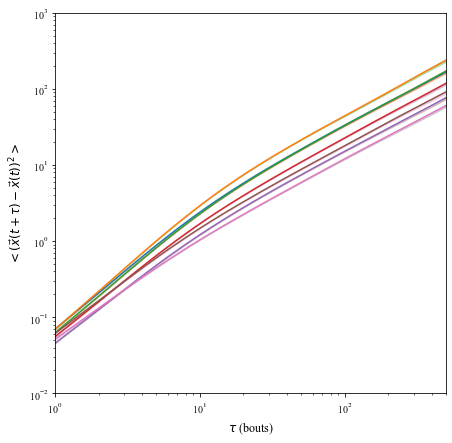

In [48]:
plt.figure(figsize=(7,7))

local_slopes =[]

for clus in [0,1,2,3,4,5,6]:
    print(clus)
    mean,cil,ciu = stats.bootstrap(mus_sim[clus],n_times=100, n_samples=len(mus_sim[clus]))
    local_slope = np.diff(np.log(mean))/np.diff(np.log(lags))
    local_slopes.append(local_slope)
    plt.plot(lags[1:],mean[1:],c='C{}'.format(clus))
    plt.fill_between(lags[1:],cil[1:],ciu[1:],alpha=.3,color='C{}'.format(clus+1))

# plt.plot(lags[1:], 0.07*lags[1:]**1.5,c='k',ls='--')
# plt.plot(lags[1:], 0.3*lags[1:]**1.,c='gray',ls='--')
plt.xlim(1,500)
plt.ylim(0.01,1000)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0.1,1.25**2)
# plt.xlim(0,15)
plt.xlabel(r'$\tau$ (bouts)',fontsize=12)
plt.ylabel(r'$<(\vec{x}(t+\tau)-\vec{x}(t))^2>$',fontsize=12)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl8/MSD_groups.pdf')
# plt.legend()
# plt.axis('equal')
plt.show()